# Happiness and Freedom

**A brief review of the World Happiness Report and Human Freedom Index in terms of how presence of freedom affects happiness.**.  
Analysis derived from data using the most recent World Happiness Report ([link](http://worldhappiness.report/)) and Human Freedom Index ([link](https://www.cato.org/human-freedom-index-new)).

"The secret to happiness is freedom... and the secret to freedom is courage." - Thucydides ([wikipedia](https://en.wikipedia.org/wiki/Thucydides))

It seems obvious that freedom leads to happiness but how much and how do different kinds of freedoms contribute to the overall picture?  We'll take a look at each category of freedom's relationship with reported happiness and it's own categories.  The aim is to create an overview of the two datasets, their relationship, and find strongly correlated categories from the two datasets.

##### General

* Freedom is positively correlated with happiness.  (A gut check)
* How do the two main categories of freedom, personal and economic, affect happiness and how does it differ in that effect?
* Examining the subcategories of personal freedom (top level).
* Examining the subcategories of economic freedom (top level).

#### Happiness in relation to individual freedom of movement

* How does freedom of movement affect happiness?  Individuals that can move freely should be more happy than those under more restrictions.
* How does gender affect freedom of movement?  Does gender play a role in in freedom of movement.  How does this affect happiness?

##### Happiness and relative geographic isolation

* How does geographic isolation relate to happiness?  Are people in landlocked countries less happy than those in coastal countries?
* How does geographic isolation relate to freedom of movement?  Are people in landlocked countries or coastal countries more free to move around?

#### Happiness Subcategories

* How is each category related to overall happiness and rank?
* How does each correlate to the strongest freedom category?


In [1]:
# imports
import sqlite3
import sqlalchemy as sa
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import scipy
from scipy.stats import linregress

# create sqlite database and path
from sqlalchemy import create_engine
engine = create_engine('sqlite:///Happiness_Freedom.db')

# set seaborn default theme
sns.set_palette("muted")

# multiple outputs from single cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [45]:
# create dataframes for each report from csv
hfi_file = pd.read_csv("hfi_cc_2018.csv")
hfi = pd.DataFrame(hfi_file)

whr_file = pd.read_csv("whr_2017.csv")
whr = pd.DataFrame(whr_file)

# create database and tables from dataframe
hfi.to_sql("Human Freedom Index", con=engine, if_exists="replace")
whr.to_sql("World Happiness Report", con=engine, if_exists="replace")

x = pd.concat([hfi, whr], sort=False)
x.shape
x.head(3)
y = x.pop('Happiness.Score').values
y
z = x["region"].value_counts()
z

(1613, 135)

,year,ISO_code,countries,region,pf_rol_procedural,pf_rol_civil,pf_rol_criminal,pf_rol,pf_ss_homicide,pf_ss_disappearances_disap,...,Happiness.Score,Whisker.high,Whisker.low,Economy..GDP.per.Capita.,Family,Health..Life.Expectancy.,Freedom,Generosity,Trust..Government.Corruption.,Dystopia.Residual
0,2016.0,ALB,Albania,Eastern Europe,6.661503,4.547244,4.666508,5.291752,8.920429,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016.0,DZA,Algeria,Middle East & North Africa,NaN,NaN,NaN,3.819566,9.456254,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016.0,AGO,Angola,Sub-Saharan Africa,NaN,NaN,NaN,3.451814,8.060260,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


array([       nan,        nan,        nan, ..., 3.34899998, 2.90499997,
       2.69300008])

Sub-Saharan Africa               378
Latin America & the Caribbean    234
Eastern Europe                   198
Middle East & North Africa       171
Western Europe                   162
South Asia                       153
East Asia                         54
Caucasus & Central Asia           54
Oceania                           36
North America                     18
Name: region, dtype: int64

### Happiness is directly correlated with freedom

Let's start with a quick sanity check and make sure the happiness and freedom have a strong positive relationship.

,Country,Happiness
0,Norway,7.537
1,Denmark,7.522
2,Iceland,7.504


Text(0.5,1,'Correlation of Happiness and Freedom')

LinregressResult(slope=0.6867913461953111, intercept=0.6236133610477834, rvalue=0.6330361581269445, pvalue=1.7569182578216024e-16, stderr=0.07282491965464152)

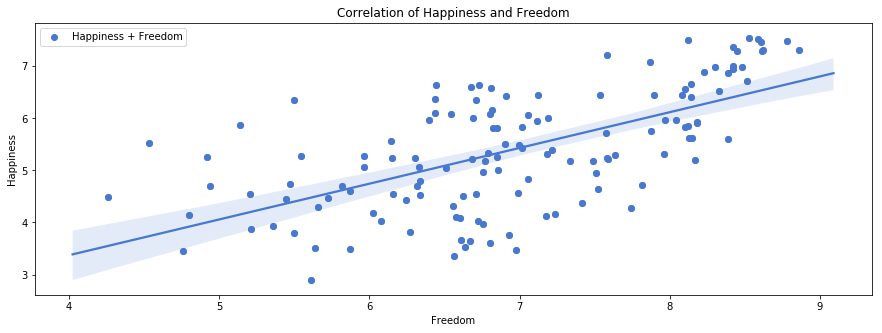

In [37]:
# get overall freedom score by country from World Freedom Report
hf_score_by_country = hfi[["countries", "hf_score"]]
hf_score_by_country.columns = ["Country", "Freedom"]

# get overall happiness score by country from Happiness Index
wh_score_by_country = whr[["Country", "Happiness.Score"]]
# rename "Country" column to "countries" to merge on conat with freedom index
wh_score_by_country.columns = ["Country", "Happiness"]

# coombine the two dataframes
reports_combined = pd.concat([hf_score_by_country, wh_score_by_country], sort=False)
wh_score_by_country.head(3)
reports_grouped = reports_combined.groupby("Country")["Freedom", "Happiness"].mean()
hf_wh_scores = reports_grouped.dropna()
hf_wh_scores.columns = ["Freedom", "Happiness"]
hf_wh_scores.index.name = "Country"

# Scatter/regression plot of happiness vs freedom
fig, ax = plt.subplots(figsize=(15, 5))
sns.regplot(x="Freedom", y="Happiness", data=hf_wh_scores)
points = plt.scatter(hf_wh_scores["Freedom"], hf_wh_scores["Happiness"], label="Happiness + Freedom")
ax.set_title("Correlation of Happiness and Freedom")
ax.legend();

x = hf_wh_scores["Freedom"]
y = hf_wh_scores["Happiness"]
linregress(x,y)

### How the top and bottom 10 countries compare in happiness to freedom

Let's look at how the top 10 and bottom 10 countries compare in level of happiness.

So that we can consider both the overall happiness and freedom scores for each country, we will create a Happiness/Freedom Index by getting the mean of the 2 scores.

Text(0.5,1,'Top 10 HFI Countries')

[Text(0,0,'Norway'),
 Text(0,0,'Denmark'),
 Text(0,0,'Iceland'),
 Text(0,0,'Switzerland'),
 Text(0,0,'Finland'),
 Text(0,0,'Netherlands'),
 Text(0,0,'Canada'),
 Text(0,0,'New Zealand'),
 Text(0,0,'Australia')]

Text(0,0.5,'HFI Score')

(0, 10)

Text(0.5,1,'Bottom 10 HFI Countries')

[Text(0,0,'Madagascar'),
 Text(0,0,'Haiti'),
 Text(0,0,'Liberia'),
 Text(0,0,'Guinea'),
 Text(0,0,'Togo'),
 Text(0,0,'Rwanda'),
 Text(0,0,'Syria'),
 Text(0,0,'Tanzania'),
 Text(0,0,'Burundi')]

Text(0,0.5,'HFI Score')

(0, 10)

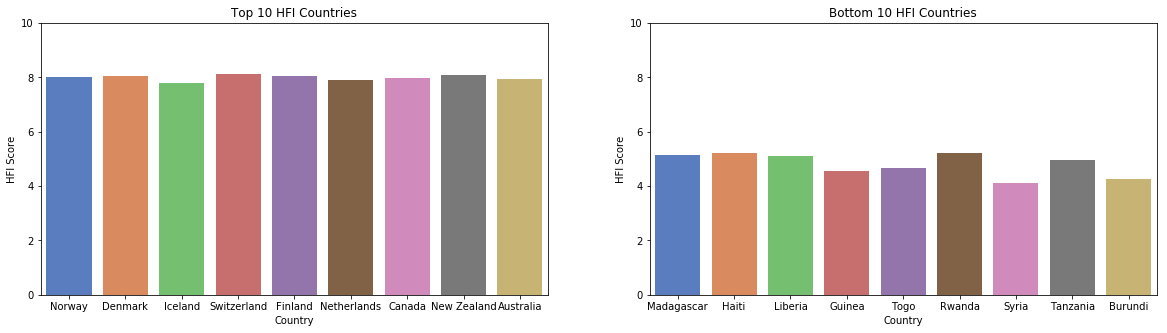

In [4]:
hf_wh_scores_reset = hf_wh_scores.reset_index()
hf_wh_scores_by_country_raw = hf_wh_scores_reset.sort_values(by=['Happiness'], ascending=False)
hf_wh_scores_by_country_raw["Combined Score"] = hf_wh_scores_by_country_raw.mean(axis=1)
hf_wh_scores_by_country_top = hf_wh_scores_by_country_raw[:9].round(2)
hf_wh_scores_by_country_bottom = hf_wh_scores_by_country_raw[-9:].round(2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
ax1 = sns.barplot(x="Country", y="Combined Score", data=hf_wh_scores_by_country_top, ax=ax1)
ax2 = sns.barplot(x="Country", y="Combined Score", data=hf_wh_scores_by_country_bottom, ax=ax2)
ax1.set_title("Top 10 HFI Countries")
ax1.set_xticklabels(hf_wh_scores_by_country_top["Country"])
ax1.set_ylabel("HFI Score")
ax1.set_ylim(0,10)
ax2.set_title("Bottom 10 HFI Countries")
ax2.set_xticklabels(hf_wh_scores_by_country_bottom["Country"])
ax2.set_ylabel("HFI Score")
ax2.set_ylim(0,10)

As expected, reported happiness and freedom have a moderate positive correlation in a linear fashion.

Slope = 0.69  
Correlation Coefficient = 0.63

### Happiness, Personal, and Economic Freedom

How does personal freedom affect happiness?

How does economic freedom affect happiness?

In [5]:
# get personal and economic freedom scores by country from World Freedom Report
pf_ef_score_by_country = hfi[["countries", "pf_score", "ef_score"]]
pf_ef_score_by_country.columns = ["Country", "Personal Freedom", "Economic Freedom"]

# coombine the two dataframes
reports_combined = pd.concat([pf_ef_score_by_country, wh_score_by_country], sort=False)
reports_grouped = reports_combined.groupby("Country")["Personal Freedom", "Economic Freedom", "Happiness"].mean()
pf_ef_scores = reports_grouped.dropna()

Text(0.5,1,'Happiness and Personal Freedom')

Text(0.5,1,'Happiness and Economic Freedom')

LinregressResult(slope=0.4792994286254869, intercept=1.9771523039640249, rvalue=0.5904565197157343, pvalue=4.8011190014548e-14, stderr=0.05680729070605633)

LinregressResult(slope=0.7572594668852657, intercept=0.2776175122816644, rvalue=0.5769568558547652, pvalue=2.4067155502762765e-13, stderr=0.09295607741457271)

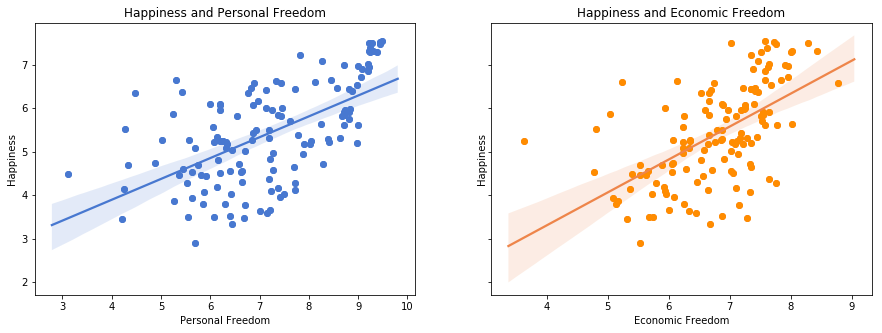

In [6]:
# regplot of happiness, personal freedom and economic freedom scores
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
sns.regplot(x="Personal Freedom", y="Happiness", data=pf_ef_scores, ax=ax1)
sns.regplot(x="Economic Freedom", y="Happiness", data=pf_ef_scores, ax=ax2)
points1 = ax1.scatter(pf_ef_scores["Personal Freedom"], pf_ef_scores["Happiness"], label="Happiness and Personal Freedom")
points2 = ax2.scatter(pf_ef_scores["Economic Freedom"], pf_ef_scores["Happiness"], c="darkorange", label="Happiness and Economic Freedom")
ax1.set_title("Happiness and Personal Freedom")
ax2.set_title("Happiness and Economic Freedom")

x = pf_ef_scores["Personal Freedom"]
y = pf_ef_scores["Happiness"]
linregress(x,y)

x = pf_ef_scores["Economic Freedom"]
y = pf_ef_scores["Happiness"]
linregress(x,y)

Both categories show a moderate to strong positive linear relationship

__Personal Freedom:__  
Slope = 0.48  
Correlation Coefficient = 0.59  

__Economic Freedom__:  
Slope = 0.78  
Correlation Coefficient = 0.58  


Both personal and economic freedom have a moderate to strong influence on happiness.

Personal Freedom:
* Slope: 0.48
* Correlation Coefficient: 0.59

Economic Freedom:
* Slope: 0.76
* Correlation Coefficient: 0.58

Text(0.5,0.98,'Happiness and Personal Freedoms')

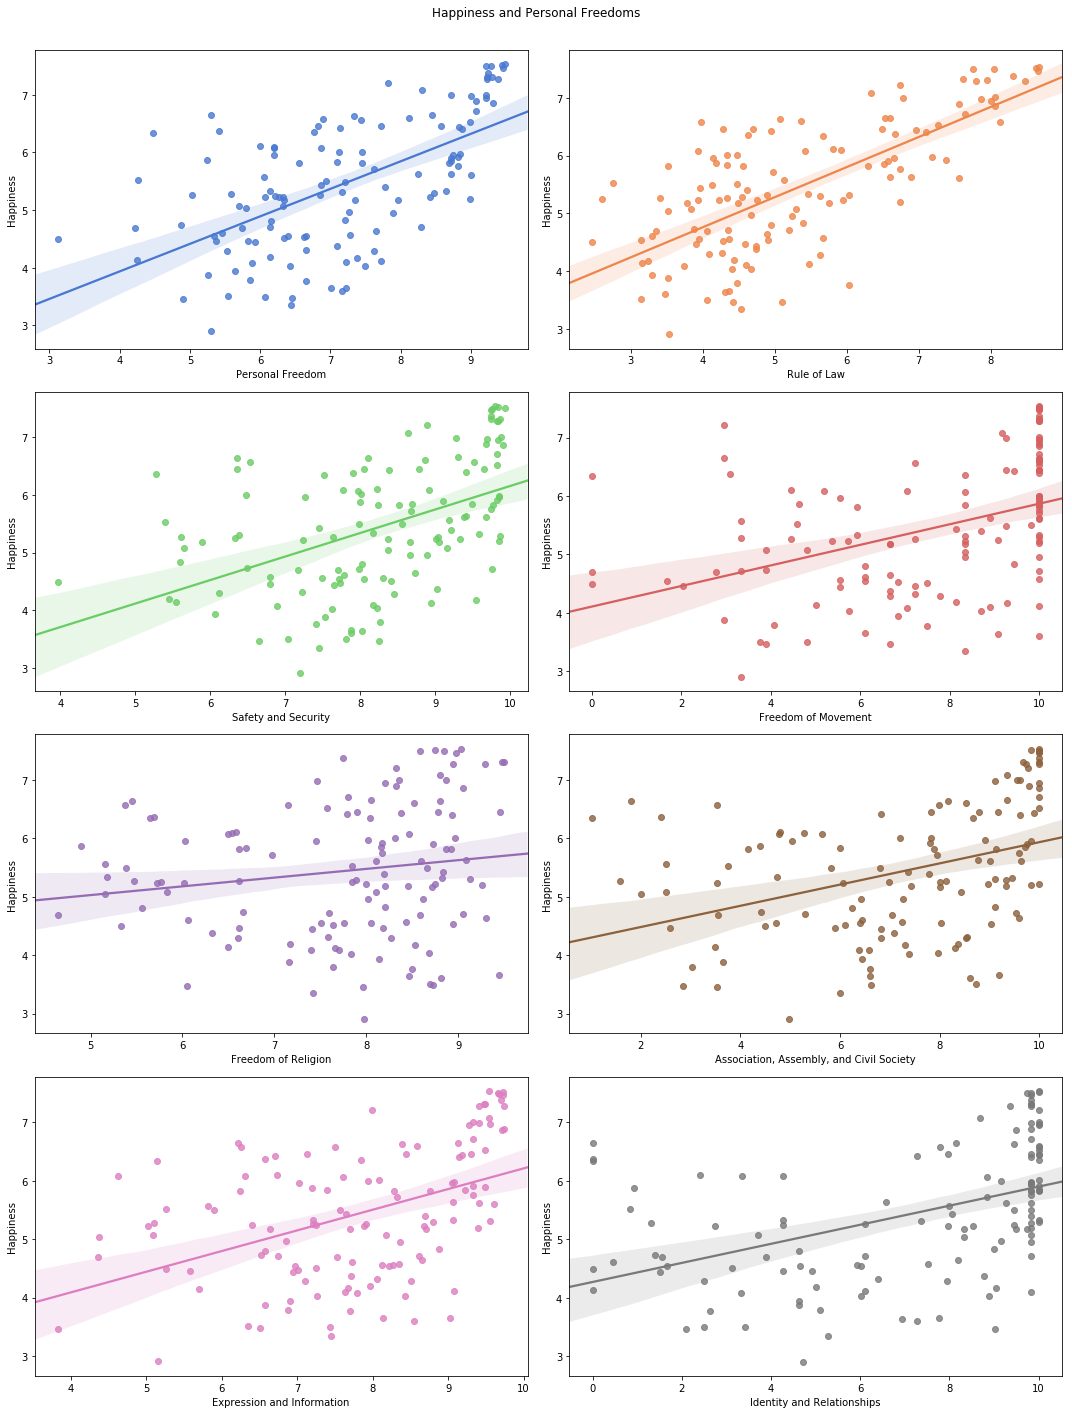

In [7]:
# Each personal freedom top level category
hfiTopLevelRaw = hfi[['countries', 'hf_score', 'pf_rol', 'pf_ss', 'pf_movement', 'pf_religion', 'pf_association', 'pf_expression', 'pf_identity', 'pf_score', 'pf_rank']]
hfiTopLevelCleaned = hfiTopLevelRaw.dropna()
hfiTopLevel = hfiTopLevelCleaned.sort_values(by='pf_rank')
hfiTopLevel.columns = ["Country", "Freedom", "Rule of Law", "Safety and Security", "Freedom of Movement", "Freedom of Religion", "Association, Assembly, and Civil Society", "Expression and Information", "Identity and Relationships", "Personal Freedom", "PF Rank"]

# coombine the two dataframes grouping by county and dropping null values
hp_pf_combined = pd.concat([hfiTopLevel, wh_score_by_country], sort=True)
hp_pf_grouped = hp_pf_combined.groupby("Country").mean()
hp_pf = hp_pf_grouped.dropna()

# plot of happiness and personal freedom subtypes
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 20))
fig.suptitle("Happiness and Personal Freedoms")

sns.regplot(x="Personal Freedom", y="Happiness", data=hp_pf, ax=axes[0,0])
sns.regplot(x="Rule of Law", y="Happiness", data=hp_pf, ax=axes[0,1])

sns.regplot(x="Safety and Security", y="Happiness", data=hp_pf, ax=axes[1,0])
sns.regplot(x="Freedom of Movement", y="Happiness", data=hp_pf, ax=axes[1,1])

sns.regplot(x="Freedom of Religion", y="Happiness", data=hp_pf, ax=axes[2,0])
sns.regplot(x="Association, Assembly, and Civil Society", y="Happiness", data=hp_pf, ax=axes[2,1])

sns.regplot(x="Expression and Information", y="Happiness", data=hp_pf, ax=axes[3,0])
sns.regplot(x="Identity and Relationships", y="Happiness", data=hp_pf, ax=axes[3,1])

plt.tight_layout()
fig.subplots_adjust(top=0.95)


Text(0.5,0.98,'Happiness and Economic Freedoms')

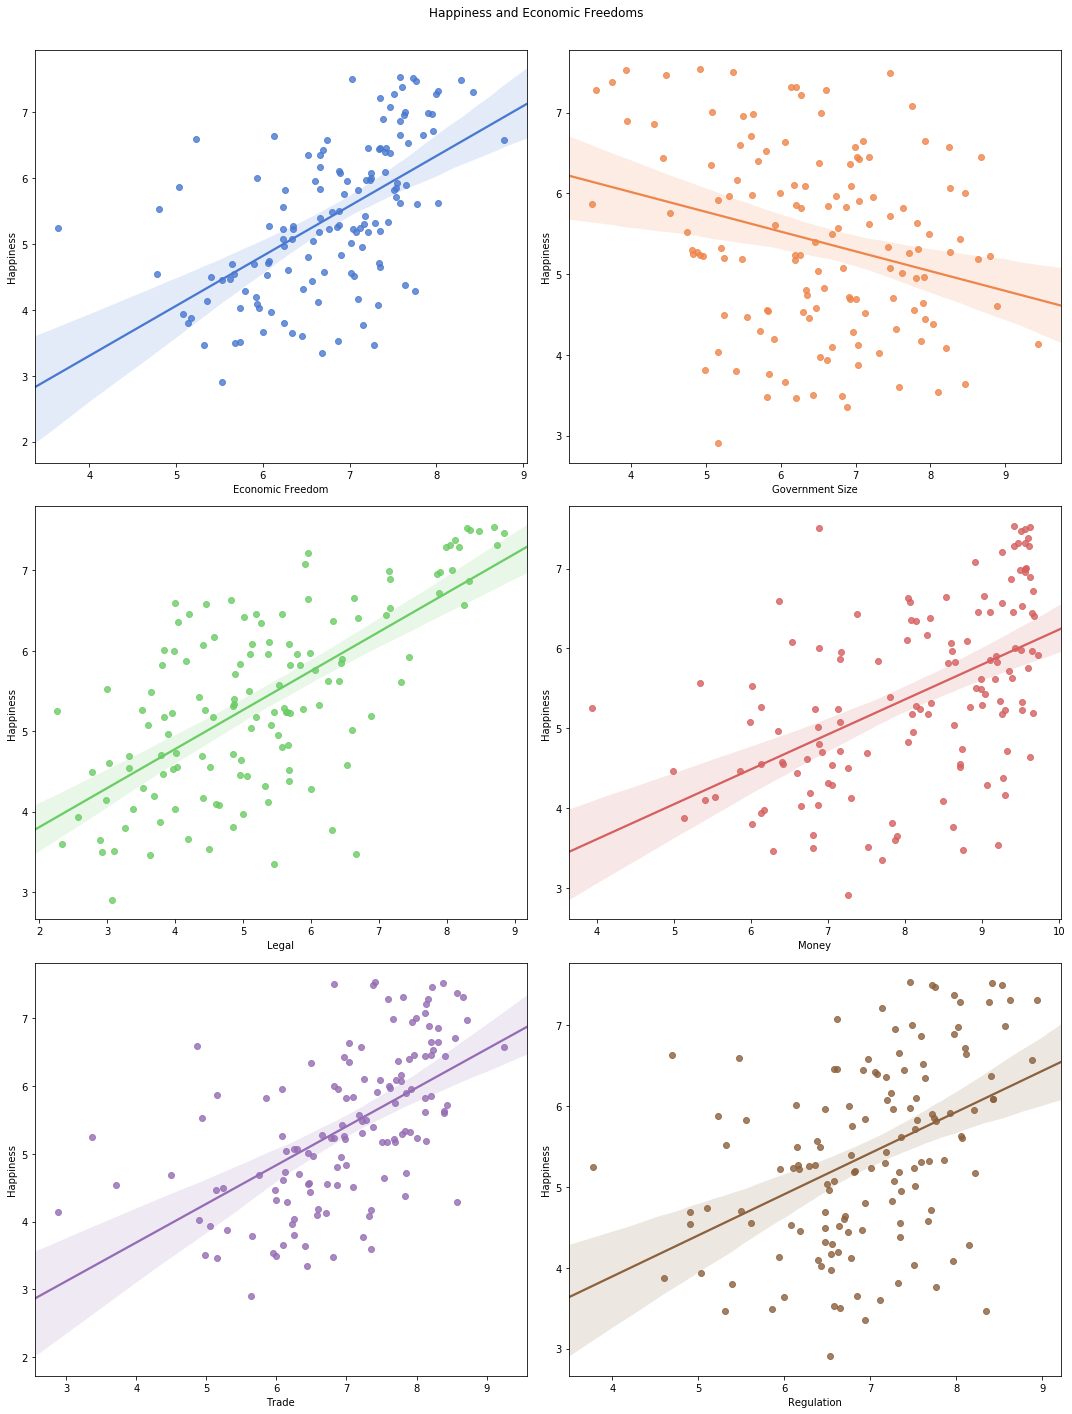

In [8]:
# Each economic freedom top level category
hfiefTopLevelRaw = hfi[['countries', 'hf_score', 'ef_government', 'ef_legal', 'ef_money', 'ef_trade', 'ef_regulation', 'ef_score', 'ef_rank']]
hfiefTopLevelCleaned = hfiefTopLevelRaw.dropna()
hfiefTopLevel = hfiefTopLevelCleaned.sort_values(by='ef_rank')
hfiefTopLevel.columns = ["Country", "Freedom", "Government Size", "Legal", "Money", "Trade", "Regulation", "Economic Freedom", "E.F. Rank"]

# coombine the two dataframes grouping by county and dropping null values
hp_ef_combined = pd.concat([hfiefTopLevel, wh_score_by_country], sort=True)
hp_ef_grouped = hp_ef_combined.groupby("Country").mean()
hp_ef = hp_ef_grouped.dropna()

# plot of happiness and personal freedom subtypes
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 20))
fig.suptitle("Happiness and Economic Freedoms")

sns.regplot(x="Economic Freedom", y="Happiness", data=hp_ef, ax=axes[0,0])
sns.regplot(x="Government Size", y="Happiness", data=hp_ef, ax=axes[0,1])

sns.regplot(x="Legal", y="Happiness", data=hp_ef, ax=axes[1,0])
sns.regplot(x="Money", y="Happiness", data=hp_ef, ax=axes[1,1])

sns.regplot(x="Trade", y="Happiness", data=hp_ef, ax=axes[2,0])
sns.regplot(x="Regulation", y="Happiness", data=hp_ef, ax=axes[2,1])

plt.tight_layout()
fig.subplots_adjust(top=0.95)


In [9]:
# slope and correlation coefficient of happiness and personal freedom
print("Freedom")
x = hp_pf["Personal Freedom"]
y = hp_pf["Happiness"]
linregress(x,y)

# slope and correlation coefficient of happiness and rule of law
print("Rule of Law")
x = hp_pf["Rule of Law"]
y = hp_pf["Happiness"]
linregress(x,y)

# slope and correlation coefficient of happiness and safety and security
print("Safety & Security")
x = hp_pf["Safety and Security"]
y = hp_pf["Happiness"]
linregress(x,y)

# slope and correlation coefficient of happiness and movement
print("Freedom of Movement")
x = hp_pf["Freedom of Movement"]
y = hp_pf["Happiness"]
linregress(x,y)

# slope and correlation coefficient of happiness and religion
print("Freedom of Religion")
x = hp_pf["Freedom of Religion"]
y = hp_pf["Happiness"]
linregress(x,y)

# slope and correlation coefficient of happiness and association, assembly, and civil society
print("Assocaition, Assembly, & Civil Society")
x = hp_pf["Association, Assembly, and Civil Society"]
y = hp_pf["Happiness"]
linregress(x,y)

# slope and correlation coefficient of happiness and expression and information
print("Expression and Information")
x = hp_pf["Expression and Information"]
y = hp_pf["Happiness"]
linregress(x,y)

# slope and correlation coefficient of happiness and identity and relationships
print("Identity & Relationships")
x = hp_pf["Identity and Relationships"]
y = hp_pf["Happiness"]

linregress(x,y)

Freedom


LinregressResult(slope=0.4777702078099344, intercept=2.025502250415107, rvalue=0.6040153962848803, pvalue=4.4258228174790305e-14, stderr=0.056160271690753764)

Rule of Law


LinregressResult(slope=0.5209979129866191, intercept=2.673713371293317, rvalue=0.7141489422965056, pvalue=2.990674396433896e-21, stderr=0.045494206338710354)

Safety & Security


LinregressResult(slope=0.4080258604239287, intercept=2.0741299252078877, rvalue=0.47480012725507825, pvalue=1.4929626955929245e-08, stderr=0.06737836672643274)

Freedom of Movement


LinregressResult(slope=0.17634965652883489, intercept=4.106094261023734, rvalue=0.4171563227037659, pvalue=9.65709798471237e-07, stderr=0.03422752050614893)

Freedom of Religion


LinregressResult(slope=0.14964831068730947, intercept=4.281119791280521, rvalue=0.15955172053151812, pvalue=0.07202557542989964, stderr=0.08248701974809576)

Assocaition, Assembly, & Civil Society


LinregressResult(slope=0.1818249970047164, intercept=4.117945123473065, rvalue=0.3820964026005794, pvalue=8.563369744181416e-06, stderr=0.03917643360180846)

Expression and Information


LinregressResult(slope=0.3539864950937236, intercept=2.673699994740398, rvalue=0.4468126638142697, pvalue=1.2445335746662996e-07, stderr=0.06314198240634508)

Identity & Relationships


LinregressResult(slope=0.16300294165747645, intercept=4.26946316335665, rvalue=0.45745928863151136, pvalue=5.6800425635965134e-08, stderr=0.028227479562365345)

#### Analysis:

**Strong relationship**: Rule of Law (0.71)

**Weak to moderate**: Saftey & Security (0.48), Movement (0.42), Association, Assembly, and Civil Society (0.38), Expression and Information (0.45), Identity and Relationships (0.46)

**None to weak** Relgion (0.16)

From the r values, Rule of Law shows to highest correlation with happiness, while all other categories except Religion show a weak to moderate correlation to happiness.

### Happiness and Movement Freedom

Text(0.5,1,'Correlation of General Happiness and Movement Freedom')

Text(0.5,0,'Freedom of Movement')

Text(0,0.5,'Happiness Score')

LinregressResult(slope=0.19384737724068232, intercept=3.865210669228947, rvalue=0.40395224050215855, pvalue=3.948639184319359e-06, stderr=0.0400733806885717)

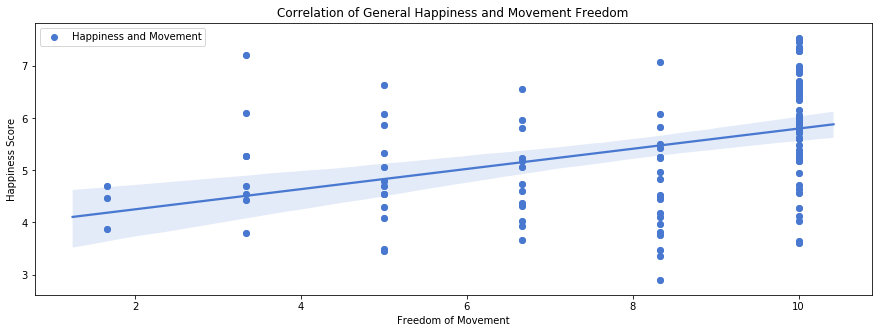

In [10]:
# Happiness and Movement Freedom

# retrieve movement data from Human Freedom Index grouped by country and ordered by movement score
hfi_movement_by_country_data = "SELECT countries, pf_movement, pf_movement_domestic, pf_movement_foreign, pf_movement_women FROM 'Human Freedom Index' GROUP BY countries ORDER BY pf_score DESC"
hfi_movement_by_country_raw = pd.read_sql(hfi_movement_by_country_data, con=engine)
hfi_movement_by_country = hfi_movement_by_country_raw.dropna()

# retrieve happiness score data from World Happiness Report groupd by country and ordered by happiness score
whr_happiness_by_country_data = "SELECT Country as countries, `Happiness.Score` as hp_score FROM 'World Happiness Report' GROUP BY countries ORDER BY hp_score DESC"
whr_happiness_by_country_raw = pd.read_sql(whr_happiness_by_country_data, con=engine)
whr_happiness_by_country = whr_happiness_by_country_raw.dropna()

# coombine the two dataframes grouping by county and dropping null values
hfi_movement_whr_happiness_by_country_combined = pd.concat([hfi_movement_by_country, whr_happiness_by_country], sort=True)
hfi_movement_whr_happiness_by_country_grouped = hfi_movement_whr_happiness_by_country_combined.groupby("countries")["hp_score", "pf_movement", "pf_movement_domestic", "pf_movement_foreign", "pf_movement_women"].mean()
hfi_movement_whr_happiness_by_country = hfi_movement_whr_happiness_by_country_grouped.dropna()
hfi_movement_whr_happiness_by_country.columns = ["Happiness", "Freedom of Movement", "Domestic Movement Freedom", "Foreign Movement Freedom", "Women's Movement Freedom"]

# scatter plot analysis with linear regression
fig, ax = plt.subplots(figsize=(15, 5))
sns.regplot(x="Freedom of Movement", y="Happiness", data=hfi_movement_whr_happiness_by_country)
points = plt.scatter(hfi_movement_whr_happiness_by_country["Freedom of Movement"], hfi_movement_whr_happiness_by_country["Happiness"], label="Happiness and Movement")
ax.set_title("Correlation of General Happiness and Movement Freedom")
ax.set_xlabel("Freedom of Movement")
ax.set_ylabel("Happiness Score")
ax.legend()

x = hfi_movement_whr_happiness_by_country["Freedom of Movement"]
y = hfi_movement_whr_happiness_by_country["Happiness"]
linregress(x,y)

Slope = 0.19   
Correlation Coefficient = 0.40

## Happiness and types of movment

Text(0.5,0.98,'Happiness and Freedom of Movement')

LinregressResult(slope=0.19384737724068232, intercept=3.865210669228947, rvalue=0.40395224050215855, pvalue=3.948639184319359e-06, stderr=0.0400733806885717)

LinregressResult(slope=0.12524635510928528, intercept=4.486462509188343, rvalue=0.3986688491682361, pvalue=5.41240705840397e-06, stderr=0.026301255055421024)

LinregressResult(slope=0.09322213476133365, intercept=4.733206502033217, rvalue=0.2967332753905574, pvalue=0.0009038423009149428, stderr=0.02738719365529842)

LinregressResult(slope=0.11382046038111927, intercept=4.411231037694739, rvalue=0.18839487581167114, pvalue=0.0376988147725481, stderr=0.05416433358800328)

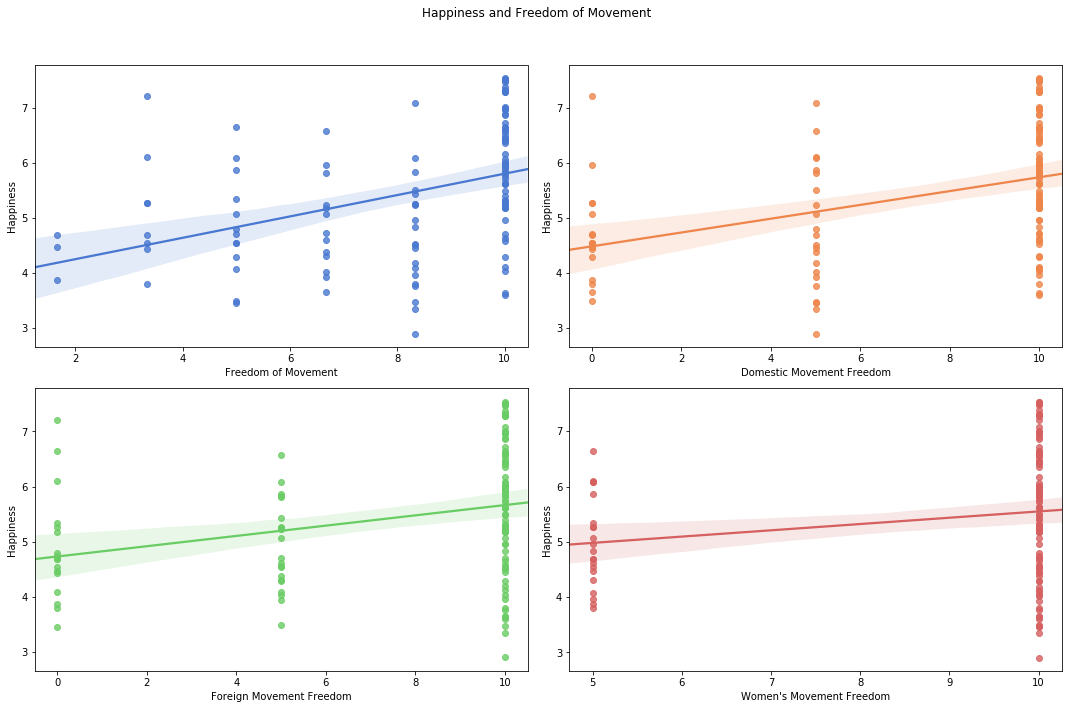

In [11]:
# Correlation of happiness and all movement freedom types

# plot of happiness freedom and personal freedom subtypes
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
fig.suptitle("Happiness and Freedom of Movement")

sns.regplot(x="Freedom of Movement", y="Happiness", data=hfi_movement_whr_happiness_by_country, ax=axes[0,0])
sns.regplot(x="Domestic Movement Freedom", y="Happiness", data=hfi_movement_whr_happiness_by_country, ax=axes[0,1])

sns.regplot(x="Foreign Movement Freedom", y="Happiness", data=hfi_movement_whr_happiness_by_country, ax=axes[1,0])
sns.regplot(x="Women's Movement Freedom", y="Happiness", data=hfi_movement_whr_happiness_by_country, ax=axes[1,1])

plt.tight_layout()
fig.subplots_adjust(top=0.9)

# slope and correlation coefficient of happiness and personal freedom
x = hfi_movement_whr_happiness_by_country["Freedom of Movement"]
y = hfi_movement_whr_happiness_by_country["Happiness"]
linregress(x,y)

x = hfi_movement_whr_happiness_by_country["Domestic Movement Freedom"]
y = hfi_movement_whr_happiness_by_country["Happiness"]
linregress(x,y)

x = hfi_movement_whr_happiness_by_country["Foreign Movement Freedom"]
y = hfi_movement_whr_happiness_by_country["Happiness"]
linregress(x,y)

x = hfi_movement_whr_happiness_by_country["Women's Movement Freedom"]
y = hfi_movement_whr_happiness_by_country["Happiness"]
linregress(x,y)

### Analysis:

**Weak to moderate**:  Domestic Travel (0.40), Foreign Trave (0.30), Women's Movement (0.19) 

Domestic travel has the strongest correlation with happiness which seems to be a benefit for isolated countries.

## Happiness and geographic isolation

In [12]:
# get list of land locked countries
land_locked_countries = pd.Series(["Afghanistan", "Andorra", "Armenia", "Artsakh", "Austria", "Azerbaijan", "Belarus", "Bhutan", "Bolivia", "Botswana", "Burkina Faso", "Burundi", "Central African Republic", "Chad", "Czech Republic", "Ethiopia", "Hungary","Kazakhstan", "Kosovo", "Kyrgyzstan", "Laos", "Lesotho", "Liechtenstein", "Luxembourg", "Macedonia", "Malawi", "Mali", "Moldova", "Mongolia", "Nepal", "Niger", "Paraguay", "Rwanda", "San Marino" , "Serbia", "Slovakia", "South Ossetia", "South Sudan", "Swaziland", "Switzerland","Tajikistan", "Transnistria", "Turkmenistan", "Uganda", "Uzbekistan","Vatican City", "West Bank", "Zambia", "Zimbabwe"])

Text(0.5,1,'Happiness range in countries based on geography')

(0, 10)

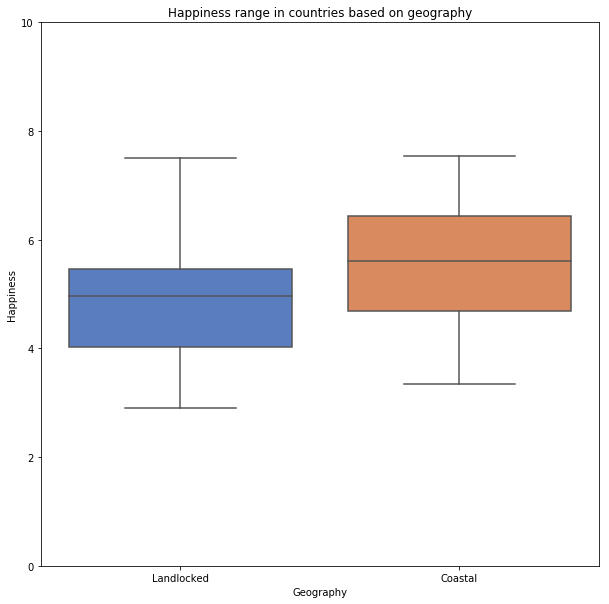

In [13]:
# create list of land-locked countries and coastal countries
landlocked_happiness = hf_wh_scores_by_country_raw.loc[hf_wh_scores_by_country_raw["Country"].isin(land_locked_countries)]
coastal_happiness = hf_wh_scores_by_country_raw.loc[~hf_wh_scores_by_country_raw["Country"].isin(land_locked_countries)]

# combine dataframes
combined_happiness_raw = pd.concat([landlocked_happiness, coastal_happiness])
combined_happiness = combined_happiness_raw.drop(columns=["Combined Score"])

# mark countries as landlocked or coastal
combined_happiness["Geography"] = ""
combined_happiness["Geography"] = np.where(combined_happiness["Country"].isin(land_locked_countries), "Landlocked", "Coastal")
combined_happiness = combined_happiness.sort_values(by="Happiness").drop(columns=["Country"])

fig, ax = plt.subplots(figsize=(10,10))
sns.boxplot(x="Geography", y="Happiness", data=combined_happiness)
ax.set_title("Happiness range in countries based on geography")
ax.set_ylim(0, 10)

Text(0.5,1,'Happiness in Landlocked vs Coastal Countries')

(0, 10)

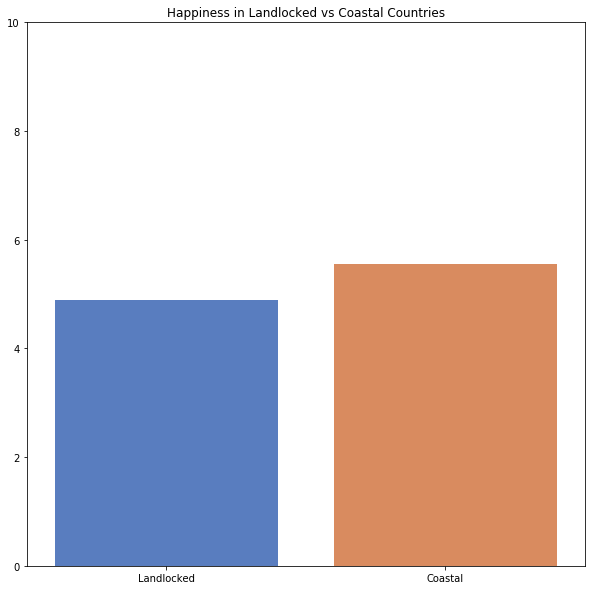

In [14]:
# avg happiness in landlocked vs coastal countries

landlocked_happiness_mean = landlocked_happiness["Happiness"].mean()
coastal_happiness_mean = coastal_happiness["Happiness"].mean()

# combine into data array

combined_happiness_mean = pd.DataFrame([landlocked_happiness_mean, coastal_happiness_mean]).T 

combined_happiness_mean.columns = ["Landlocked", "Coastal"]
combined_happiness_mean.index = ["Happiness"]

# plot

fig, ax = plt.subplots(figsize=(10, 10))
ax = sns.barplot(data=combined_happiness_mean);
ax.set_title("Happiness in Landlocked vs Coastal Countries")
ax.set_ylim(0, 10)

Text(0.5,1,'Correlation of Happiness and Freedom in Landlocked vs non-Landlocked countries')

LinregressResult(slope=0.8786316163050915, intercept=-1.0922589058503362, rvalue=0.7158647604073939, pvalue=8.687374465791945e-06, stderr=0.16195744036889148)

LinregressResult(slope=0.6303437707662627, intercept=1.1371292209288013, rvalue=0.6179284067523297, pvalue=2.1823642234112312e-12, stderr=0.0790264944123492)

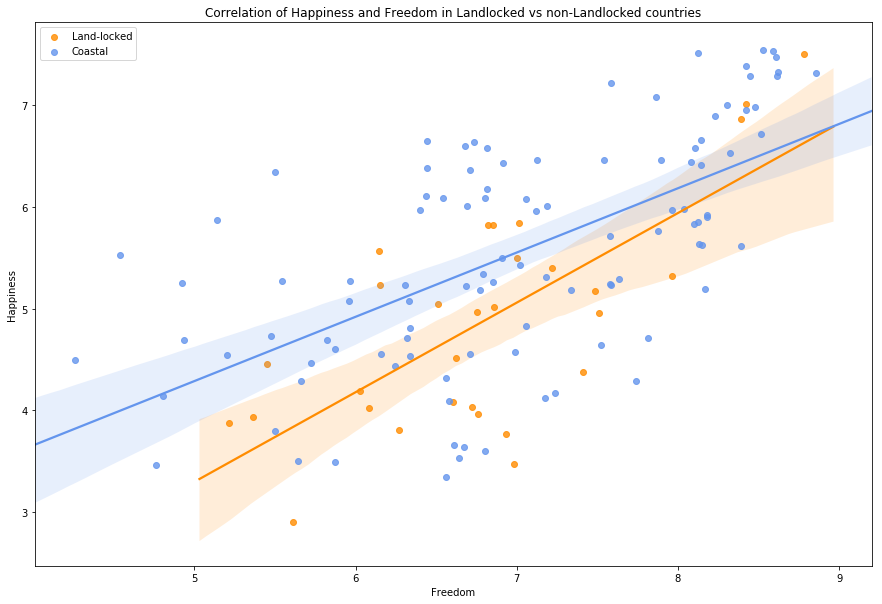

In [15]:
# Regplots of happiness and freedom for landlocked vs coastal countries

fig, ax = plt.subplots(figsize=(15,10))
sns.regplot(x="Freedom", y="Happiness", data=landlocked_happiness, color="darkorange", label="Land-locked")
sns.regplot(x="Freedom", y="Happiness", data=coastal_happiness, color="cornflowerblue", label="Coastal")
ax.set_title("Correlation of Happiness and Freedom in Landlocked vs non-Landlocked countries")
ax.legend()

# slope and correlation coefficient of happiness and personal freedom
x = landlocked_happiness["Freedom"]
y = landlocked_happiness["Happiness"]
linregress(x,y)

x = coastal_happiness["Freedom"]
y = coastal_happiness["Happiness"]
linregress(x,y)

### Happiness and movement freedom in land-locked versus coastal countries

Text(0.5,1,'Correlation of Happiness and Freedom of Movement in Landlocked vs non-Landlocked countries')

Text(0.5,0,'Freedom of Movement')

Text(0,0.5,'Happiness')

LinregressResult(slope=0.2634076329039947, intercept=2.6653812897946585, rvalue=0.4509848188048423, pvalue=0.018226123164837238, stderr=0.10426055671413943)

LinregressResult(slope=0.18566767450354887, intercept=4.109416343979116, rvalue=0.42531559049079953, pvalue=1.7355633151802674e-05, stderr=0.0409688474579896)

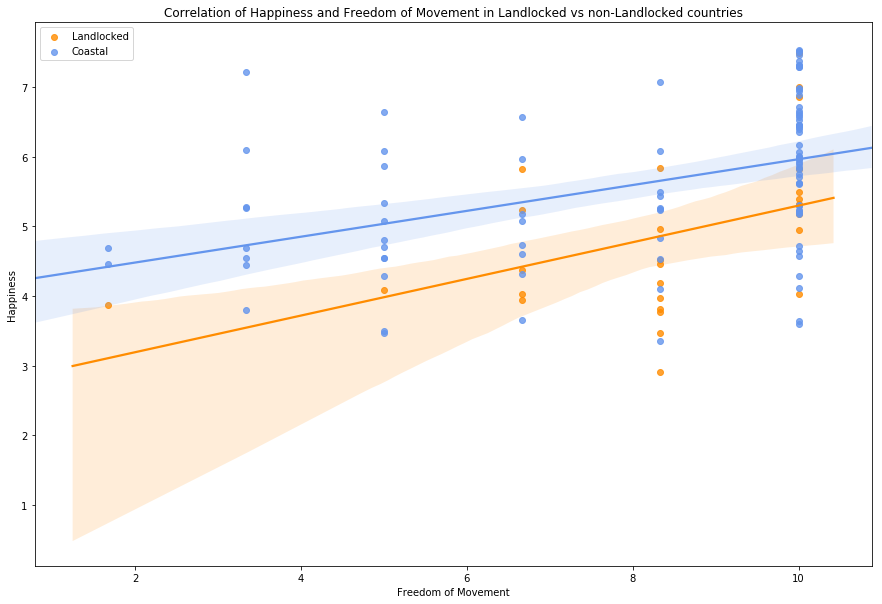

In [16]:
# reset index of dataframe from country list to index
hfi_movement_whr_happiness_by_country_reset = hfi_movement_whr_happiness_by_country.reset_index()
hfi_movement_whr_happiness_by_country_reset.rename(columns={'countries':'Country'}, inplace=True)

# create list of land-locked countries and coastal countries
landlocked_movement_happiness = hfi_movement_whr_happiness_by_country_reset.loc[hfi_movement_whr_happiness_by_country_reset["Country"].isin(land_locked_countries)]
coastal_movement_happiness = hfi_movement_whr_happiness_by_country_reset.loc[~hfi_movement_whr_happiness_by_country_reset["Country"].isin(land_locked_countries)]

fig, ax = plt.subplots(figsize=(15,10))
sns.regplot(x="Freedom of Movement", y="Happiness", data=landlocked_movement_happiness, color="darkorange", label="Landlocked")
sns.regplot(x="Freedom of Movement", y="Happiness", data=coastal_movement_happiness, color="cornflowerblue", label="Coastal")
ax.set_title("Correlation of Happiness and Freedom of Movement in Landlocked vs non-Landlocked countries")
ax.set_xlabel("Freedom of Movement")
ax.set_ylabel("Happiness")
ax.legend()

# slope and correlation coefficient of happiness and personal freedom
x = landlocked_movement_happiness["Freedom of Movement"]
y = landlocked_movement_happiness["Happiness"]
linregress(x,y)

x = coastal_movement_happiness["Freedom of Movement"]
y = coastal_movement_happiness["Happiness"]
linregress(x,y)


**Land-locked:**
Correllation Coefficient: 0.45  
**Coastal**
Correllation Coefficient: 0.43

,Country,Happiness,Rule of Law,Procedural,Civility,Criminality
0,Albania,4.644,4.9,5.666667,5.074785,4.100516
1,Argentina,6.599,5.3,6.333333,5.366584,4.343652
2,Australia,7.284,7.8,8.800000,7.232831,7.236429


Text(0.5,1,'Happiness and Rule of Law in Landlocked vs non-Landlocked countries')

LinregressResult(slope=0.3156766270845451, intercept=3.2925441143025735, rvalue=0.3510414772345616, pvalue=0.16710165074245756, stderr=0.21741083093110536)

LinregressResult(slope=0.46065690745502824, intercept=3.083587430161188, rvalue=0.6753375912198023, pvalue=1.4309335017899922e-10, stderr=0.06100555419977643)

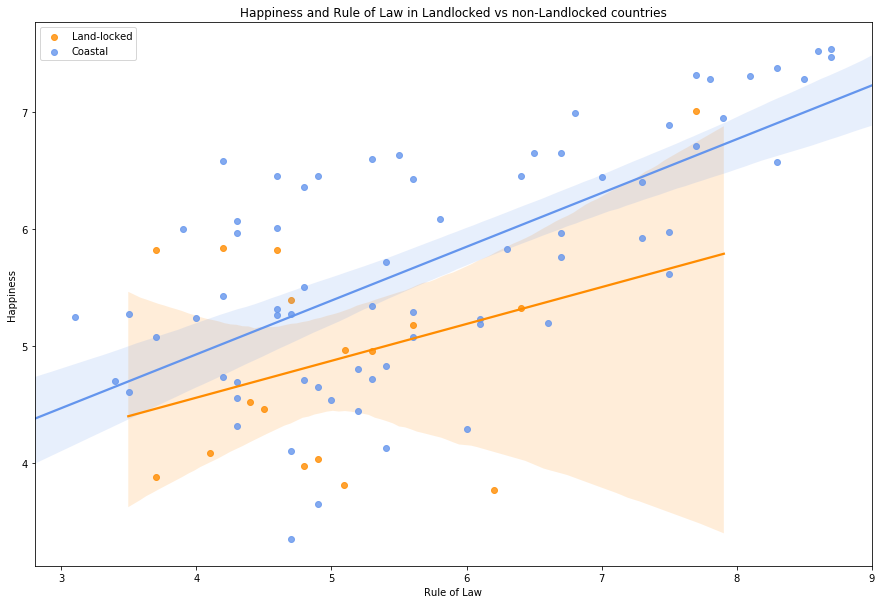

In [17]:
# combine Rule of Law from HFI with Happiness 

# retrieve movement data from Human Freedom Index grouped by country and ordered by movement score
hfi_rol_data = "SELECT countries AS Country, pf_rol AS 'Rule of Law', pf_rol_procedural AS 'Procedural', pf_rol_civil AS 'Civility', pf_rol_criminal AS 'Criminality' FROM 'Human Freedom Index' GROUP BY Country ORDER BY pf_score DESC"
hfi_rol_raw = pd.read_sql(hfi_rol_data, con=engine)
hfi_rol_by_country = hfi_rol_raw.dropna()

# coombine the two dataframes grouping by county and dropping null values
whr_happiness_by_country.columns = ["Country", "Happiness"]
hfi_rol_whr_happiness_by_country_combined = pd.concat([hfi_rol_by_country, whr_happiness_by_country], sort=True)
hfi_rol_whr_happiness_by_country_grouped = hfi_rol_whr_happiness_by_country_combined.groupby("Country")["Happiness", "Rule of Law", "Procedural", "Civility", "Criminality"].mean()
hfi_rol_whr_happiness_by_country_cleaned = hfi_rol_whr_happiness_by_country_grouped.dropna()
hfi_rol_whr_happiness_by_country = hfi_rol_whr_happiness_by_country_cleaned.reset_index()
hfi_rol_whr_happiness_by_country.head(3)

# list non land locked countries

landlocked_rol_happiness = hfi_rol_whr_happiness_by_country.loc[hfi_rol_whr_happiness_by_country["Country"].isin(land_locked_countries)]
coastal_rol_happiness = hfi_rol_whr_happiness_by_country.loc[~hfi_rol_whr_happiness_by_country["Country"].isin(land_locked_countries)]

fig, ax = plt.subplots(figsize=(15,10))
sns.regplot(x="Rule of Law", y="Happiness", data=landlocked_rol_happiness, color="darkorange", label="Land-locked")
sns.regplot(x="Rule of Law", y="Happiness", data=coastal_rol_happiness, color="cornflowerblue", label="Coastal")
ax.set_title("Happiness and Rule of Law in Landlocked vs non-Landlocked countries")
ax.legend()

# slope and correlation coefficient of happiness and personal freedom
x = landlocked_rol_happiness["Rule of Law"]
y = landlocked_rol_happiness["Happiness"]
linregress(x,y)

x = coastal_rol_happiness["Rule of Law"]
y = coastal_rol_happiness["Happiness"]
linregress(x,y)

#### Happiness Subcategories

* How is each category related to overall happiness and rank?
* How does each correlate to the strongest freedome category, Rule of Law?

In [18]:
whr.columns = ["Country", "Happiness Rank", "Happiness", "Error High", "Error Low", "Economy (GDP)", "Family", "Health & Life Expectancy", "Freedom", "Generosity", "Trust Government/Corruption", "Dystopia Residual"]
whr.columns

Index(['Country', 'Happiness Rank', 'Happiness', 'Error High', 'Error Low',
       'Economy (GDP)', 'Family', 'Health & Life Expectancy', 'Freedom',
       'Generosity', 'Trust Government/Corruption', 'Dystopia Residual'],
      dtype='object')

Text(0.5,0.98,'Happiness and Categories of Happiness')

Text(0,0.5,'Happiness')

Text(0.5,0,'Economy (GDP)')

Text(0,0.5,'Happiness')

Text(0.5,0,'Family')

Text(0,0.5,'Happiness')

Text(0.5,0,'Health & Life Expectancy')

Text(0,0.5,'Happiness')

Text(0.5,0,'Freedom')

Text(0,0.5,'Happiness')

Text(0.5,0,'Generosity')

Text(0.5,0,'Trust Government/Corruption')

Text(0,0.5,'Happiness')

Text(0.5,0,'Dystopia Residual')

Text(0,0.5,'Happiness')

(0.03676434140336969, 1.9365936848606855, 5.059548291206361, 5.648490420341491)

LinregressResult(slope=2.18418494634968, intercept=3.2032126826861895, rvalue=0.8124687538866411, pvalue=1.1103905896577026e-37, stderr=0.12670948047262018)

LinregressResult(slope=2.9642475152321612, intercept=1.8298321531238786, rvalue=0.7527366726961482, pvalue=1.4163391139613932e-29, stderr=0.20958677033185413)

LinregressResult(slope=3.731201709128991, intercept=3.296855685378315, rvalue=0.7819506247990082, pvalue=3.2129704689696394e-33, stderr=0.24046337464539952)

LinregressResult(slope=4.29978634185502, intercept=3.59632701293551, rvalue=0.5701371935975071, pvalue=9.687898897859464e-15, stderr=0.5009051793321112)

LinregressResult(slope=1.303083619420964, intercept=5.032309548004588, rvalue=0.1552558391127446, pvalue=0.05373250407926211, stderr=0.6703171217895824)

LinregressResult(slope=4.774591796345778, intercept=4.766170560287328, rvalue=0.4290797372221718, pvalue=2.5383106997415988e-08, stderr=0.8125844091082514)

LinregressResult(slope=1.0754110388489102, intercept=3.364253195122525, rvalue=0.47535512431329935, pvalue=4.10237986856995e-10, stderr=0.16091317244367706)

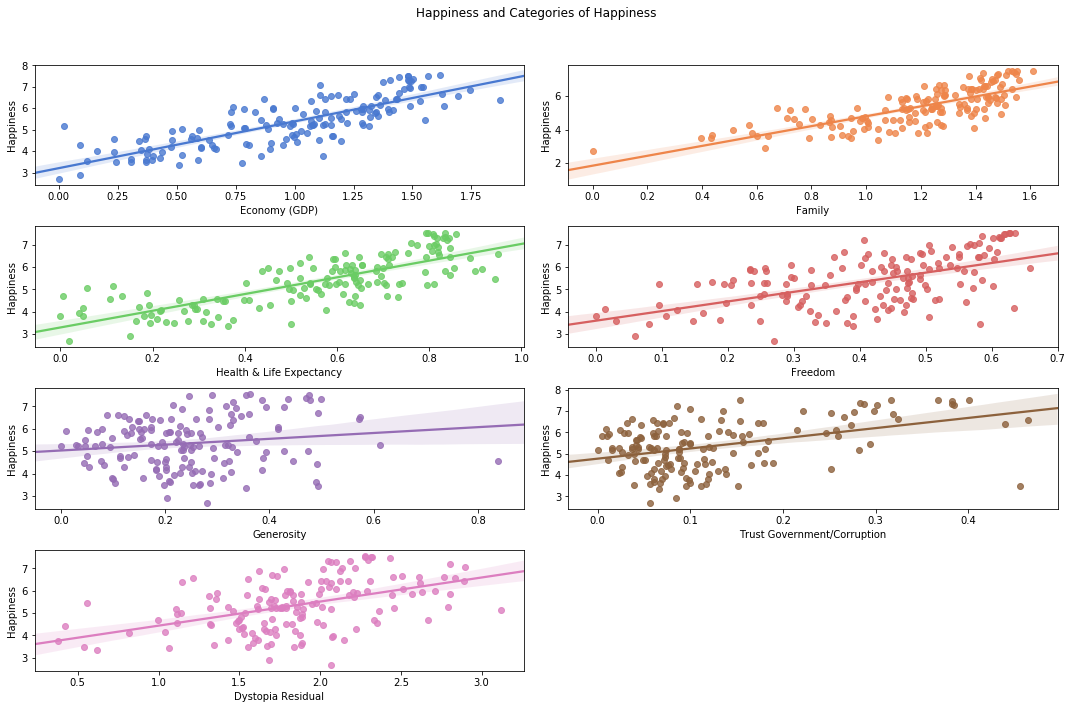

In [19]:
# plot of happiness and subtypes
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 10))
fig.suptitle("Happiness and Categories of Happiness")

sns.regplot(x="Economy (GDP)", y="Happiness", data=whr, ax=axes[0,0])
sns.regplot(x="Family", y="Happiness", data=whr, ax=axes[0,1])

axes[0,0].set_ylabel("Happiness")
axes[0,0].set_xlabel("Economy (GDP)")
axes[0,1].set_ylabel("Happiness")
axes[0,1].set_xlabel("Family")

sns.regplot(x="Health & Life Expectancy", y="Happiness", data=whr, ax=axes[1,0])
sns.regplot(x="Freedom", y="Happiness", data=whr, ax=axes[1,1])

axes[1,0].set_ylabel("Happiness")
axes[1,0].set_xlabel("Health & Life Expectancy")
axes[1,1].set_ylabel("Happiness")
axes[1,1].set_xlabel("Freedom")

sns.regplot(x="Generosity", y="Happiness", data=whr, ax=axes[2,0])
sns.regplot(x="Trust Government/Corruption", y="Happiness", data=whr, ax=axes[2,1])

axes[2,0].set_ylabel("Happiness")
axes[2,0].set_xlabel("Generosity")
axes[2,1].set_xlabel("Trust Government/Corruption")
axes[2,1].set_ylabel("Happiness")

sns.regplot(x="Dystopia Residual", y="Happiness", data=whr, ax=axes[3,0])

axes[3,0].set_xlabel("Dystopia Residual")
axes[3,0].set_ylabel("Happiness")
axes[3,1].axis("off") #https://stackoverflow.com/questions/40081489/matplotlib-odd-subplots

plt.tight_layout()
fig.subplots_adjust(top=0.9)

# slope and correlation coefficient of happiness and personal freedom
x = whr["Economy (GDP)"]
y = whr["Happiness"]
linregress(x,y)

x = whr["Family"]
y = whr["Happiness"]
linregress(x,y)

x = whr["Health & Life Expectancy"]
y = whr["Happiness"]
linregress(x,y)

x = whr["Freedom"]
y = whr["Happiness"]
linregress(x,y)

x = whr["Generosity"]
y = whr["Happiness"]
linregress(x,y)

x = whr["Trust Government/Corruption"]
y = whr["Happiness"]
linregress(x,y)

x = whr["Dystopia Residual"]
y = whr["Happiness"]
linregress(x,y)


In [20]:
# combine Rule of Law from HFI with Happiness 

# retrieve movement data from Human Freedom Index grouped by country and ordered by movement score
hfi_rol_data = "SELECT countries AS Country, pf_rol AS 'Rule of Law' FROM 'Human Freedom Index' GROUP BY Country ORDER BY pf_score DESC"
hfi_rol_raw = pd.read_sql(hfi_rol_data, con=engine)
hfi_rol_by_country = hfi_rol_raw.dropna()

whr_subcategories_data = "SELECT Country, [Happiness.Score] AS 'Happiness', [Economy..GDP.per.Capita.] AS 'Economy (GDP)', Family, [Health..Life.Expectancy.] AS 'Health & Life Expectancy', Freedom, Generosity, [Trust..Government.Corruption.] AS 'Trust Government/Corruption', [Dystopia.Residual] AS 'Dystopia Residual' FROM 'World Happiness Report' GROUP BY Country"
whr_subcategories_raw = pd.read_sql(whr_subcategories_data, con=engine)
whr_subcategories = whr_subcategories_raw.dropna()

# coombine the two dataframes grouping by county and dropping null values
hfi_rol_whr_happiness_subcategories_combined = pd.concat([hfi_rol_by_country, whr_subcategories], sort=True)
hfi_rol_whr_happiness_subcategories_grouped = hfi_rol_whr_happiness_subcategories_combined.groupby("Country")["Rule of Law","Happiness", "Economy (GDP)", "Family", "Health & Life Expectancy", "Freedom", "Generosity", "Trust Government/Corruption", "Dystopia Residual"].mean()
hfi_rol_whr_happiness_subcategories_cleaned = hfi_rol_whr_happiness_subcategories_grouped.dropna()
hfi_rol_whr_happiness_subcategories = hfi_rol_whr_happiness_subcategories_cleaned.reset_index()
hfi_rol_whr_happiness_subcategories.head(3)

,Country,Rule of Law,Happiness,Economy (GDP),Family,Health & Life Expectancy,Freedom,Generosity,Trust Government/Corruption,Dystopia Residual
0,Albania,4.900000,4.644,0.996193,0.803685,0.731160,0.381499,0.201313,0.039864,1.490442
1,Algeria,4.465447,5.872,1.091864,1.146217,0.617585,0.233336,0.069437,0.146096,2.567604
2,Angola,3.812441,3.795,0.858428,1.104412,0.049869,0.000000,0.097926,0.069720,1.614482


Text(0.5,0.98,'Rule of Law and Categories of Happiness')

Text(0,0.5,'Rule of Law')

Text(0.5,0,'Economy (GDP)')

Text(0,0.5,'Rule of Law')

Text(0.5,0,'Family')

Text(0,0.5,'Rule of Law')

Text(0.5,0,'Health & Life Expectancy')

Text(0,0.5,'Rule of Law')

Text(0.5,0,'Freedom')

Text(0.5,0,'Generosity')

Text(0,0.5,'Rule of Law')

Text(0.5,0,'Trust Government/Corruption')

Text(0,0.5,'Rule of Law')

Text(0.5,0,'Dystopia Residual')

Text(0,0.5,'Rule of Law')

(0.034823343379430605,
 1.9628363655579113,
 5.451108352143736,
 5.549423751717509)

LinregressResult(slope=2.6892557262920964, intercept=2.8082722719327946, rvalue=0.7477348693119308, pvalue=2.9193995976361726e-23, stderr=0.21709917389981737)

LinregressResult(slope=3.0766852638919864, intercept=1.8310748354693636, rvalue=0.588171328578403, pvalue=8.479072968901221e-13, stderr=0.38458602697736416)

LinregressResult(slope=4.3077575992320485, intercept=3.087573612354114, rvalue=0.6955379006714403, pvalue=4.370220362911217e-19, stderr=0.40453689965676093)

LinregressResult(slope=4.921288894322671, intercept=3.4962163257497103, rvalue=0.512641826639606, pvalue=1.3467492749178803e-09, stderr=0.749314810955811)

LinregressResult(slope=2.2371511696335427, intercept=4.99374970121637, rvalue=0.22455870817872461, pvalue=0.012524026561410152, stderr=0.8825453115104022)

LinregressResult(slope=8.026003340941067, intercept=4.562088101549818, rvalue=0.5816997846772402, pvalue=1.7192247828960777e-12, stderr=1.0202669528923913)

LinregressResult(slope=0.04292047445483731, intercept=5.464470421543883, rvalue=0.01529429561983572, pvalue=0.8666620736168251, stderr=0.2550888927142189)

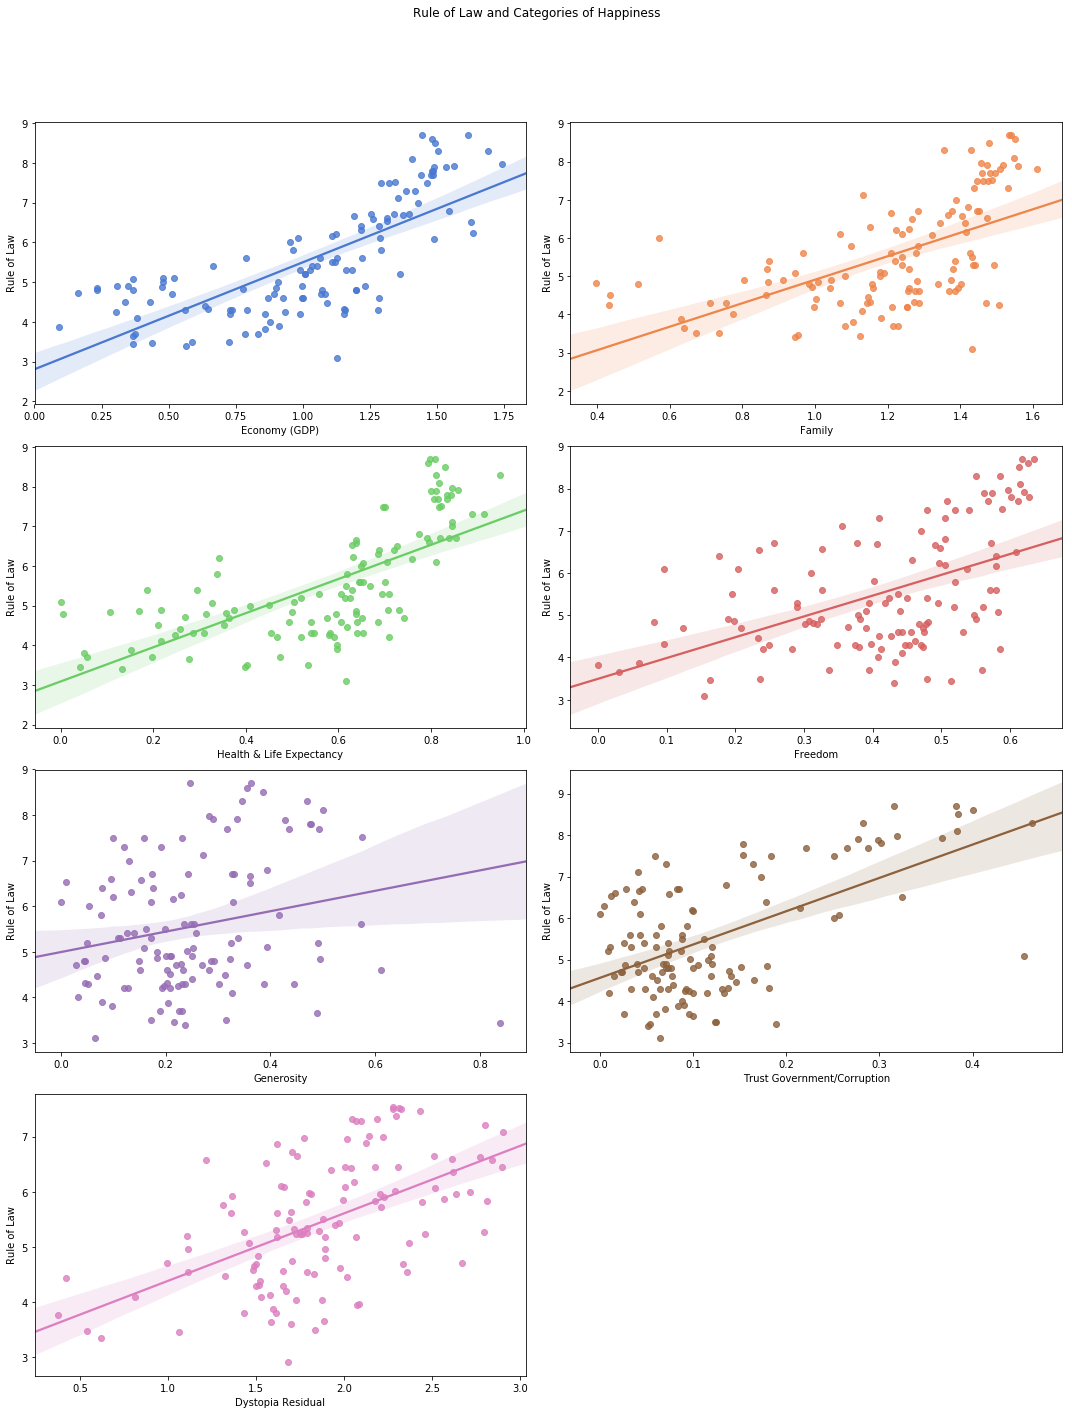

In [21]:
# plot of Rule of Law and Happiness categories
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 20))
fig.suptitle("Rule of Law and Categories of Happiness")

sns.regplot(x="Economy (GDP)", y="Rule of Law", data=hfi_rol_whr_happiness_subcategories, ax=axes[0,0])
sns.regplot(x="Family", y="Rule of Law", data=hfi_rol_whr_happiness_subcategories, ax=axes[0,1])

axes[0,0].set_ylabel("Rule of Law")
axes[0,0].set_xlabel("Economy (GDP)")
axes[0,1].set_ylabel("Rule of Law")
axes[0,1].set_xlabel("Family")

sns.regplot(x="Health & Life Expectancy", y="Rule of Law", data=hfi_rol_whr_happiness_subcategories, ax=axes[1,0])
sns.regplot(x="Freedom", y="Rule of Law", data=hfi_rol_whr_happiness_subcategories, ax=axes[1,1])

axes[1,0].set_ylabel("Rule of Law")
axes[1,0].set_xlabel("Health & Life Expectancy")
axes[1,1].set_ylabel("Rule of Law")
axes[1,1].set_xlabel("Freedom")

sns.regplot(x="Generosity", y="Rule of Law", data=hfi_rol_whr_happiness_subcategories, ax=axes[2,0])
sns.regplot(x="Trust Government/Corruption", y="Rule of Law", data=hfi_rol_whr_happiness_subcategories, ax=axes[2,1])

axes[2,0].set_xlabel("Generosity")
axes[2,0].set_ylabel("Rule of Law")
axes[2,1].set_xlabel("Trust Government/Corruption")
axes[2,1].set_ylabel("Rule of Law")

sns.regplot(x="Dystopia Residual", y="Happiness", data=hfi_rol_whr_happiness_subcategories, ax=axes[3,0])

axes[3,0].set_xlabel("Dystopia Residual")
axes[3,0].set_ylabel("Rule of Law")
axes[3,1].axis("off") #https://stackoverflow.com/questions/40081489/matplotlib-odd-subplots

plt.tight_layout()
fig.subplots_adjust(top=0.9)

# slope and correlation coefficient of happiness and personal freedom
x = hfi_rol_whr_happiness_subcategories["Economy (GDP)"]
y = hfi_rol_whr_happiness_subcategories["Rule of Law"]
linregress(x,y)

x = hfi_rol_whr_happiness_subcategories["Family"]
y = hfi_rol_whr_happiness_subcategories["Rule of Law"]
linregress(x,y)

x = hfi_rol_whr_happiness_subcategories["Health & Life Expectancy"]
y = hfi_rol_whr_happiness_subcategories["Rule of Law"]
linregress(x,y)

x = hfi_rol_whr_happiness_subcategories["Freedom"]
y = hfi_rol_whr_happiness_subcategories["Rule of Law"]
linregress(x,y)

x = hfi_rol_whr_happiness_subcategories["Generosity"]
y = hfi_rol_whr_happiness_subcategories["Rule of Law"]
linregress(x,y)

x = hfi_rol_whr_happiness_subcategories["Trust Government/Corruption"]
y = hfi_rol_whr_happiness_subcategories["Rule of Law"]
linregress(x,y)

x = hfi_rol_whr_happiness_subcategories["Dystopia Residual"]
y = hfi_rol_whr_happiness_subcategories["Rule of Law"]
linregress(x,y)
